# Problem Statement

Multiclass Image classification using custom CNN, VGG19, RESNET 50 and MOBILENET for identifying different vegetables

## Importing Libraries

In [ ]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard
from tensorflow.keras.applications import VGG16, ResNet50, MobileNet
from sklearn.metrics import confusion_matrix, classification_report

from glob import glob

# Ensure reproducibility
np.random.seed(42)

In [87]:
import tensorflow as tf
# Check if TensorFlow is using GPU
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

# List available devices
print("Available devices:")
for device in tf.config.experimental.list_physical_devices():
    print(device)

# Check if TensorFlow is using the GPU for computation
tf.debugging.set_log_device_placement(True)


Num GPUs Available:  1
Available devices:
PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')
PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')


# Folder structure
ninjacart_data\

    |train\
         
         |potato
         |tomato
         |indian market
         |onion

    |test\
         
         |potato
         |tomato
         |indian market
         |onion

### Printing some random images

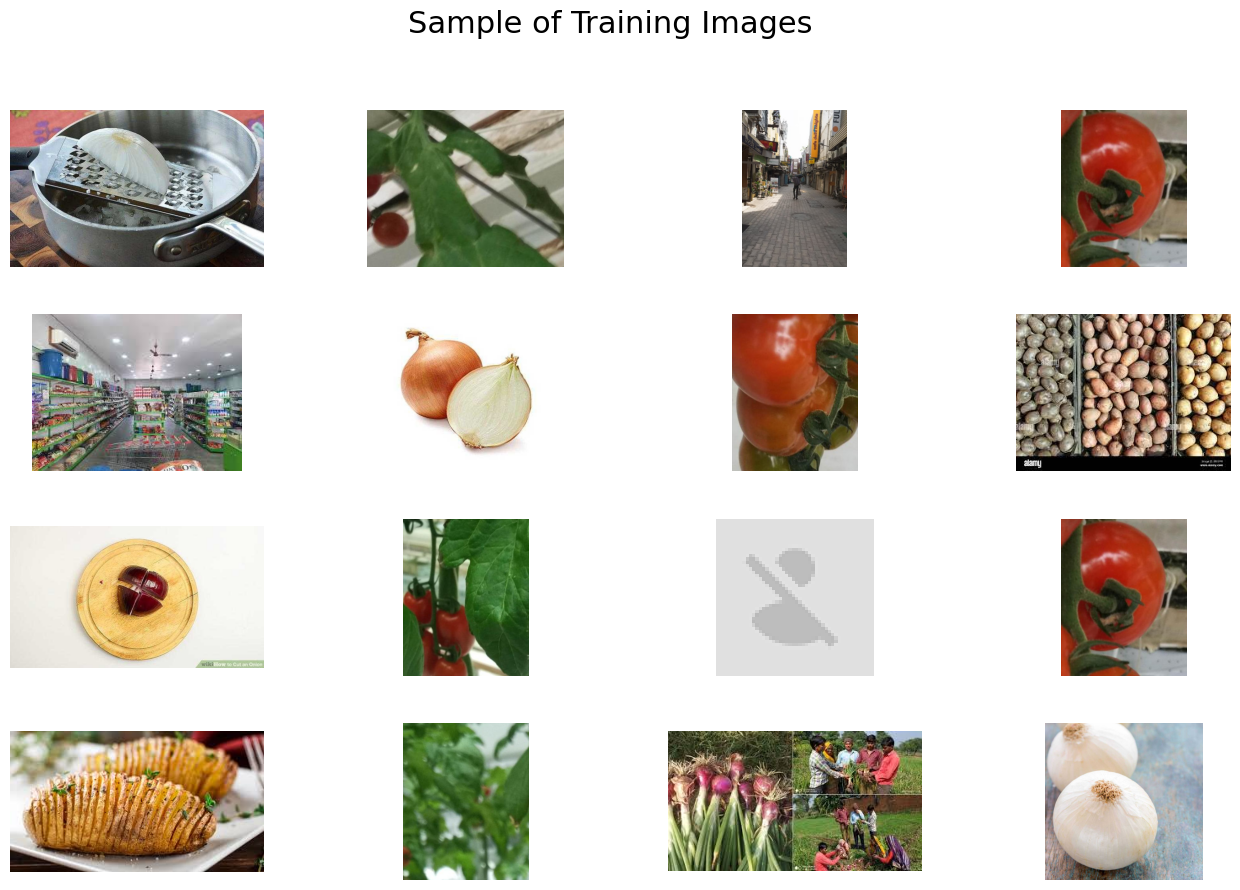

In [6]:
import os
import random
import matplotlib.pyplot as plt
import tensorflow as tf

# Define the training folder path
train_folder = r'C:\Users\Sharat\eda on python masterclass\ninjacart_data\train'

# Collect all image paths
image_paths = []
for root, dirs, files in os.walk(train_folder):
    for file in files:
        if file.endswith(('jpg', 'jpeg', 'png')):
            image_paths.append(os.path.join(root, file))

# Setup the plot
plt.figure(figsize=(16, 10))
plt.suptitle('Sample of Training Images', fontsize=22)
plt.subplots_adjust(wspace=0.3, hspace=0.3)

# Display 16 random images
for i in range(1, 17):
    plt.subplot(4, 4, i)
    random_img_path = random.choice(image_paths)
    img = tf.keras.utils.load_img(random_img_path)
    plt.imshow(img)
    plt.axis('off')

plt.show()

## Creating Train directory and counting items in each class

In [7]:
import random
import glob
import tensorflow as tf

# Directory paths
train_dir = r'C:\Users\Sharat\eda on python masterclass\ninjacart_data\train'

# Initialize dictionaries to store image arrays and counts
image_dict = {}
count_dict = {}

# List all directories (classes) inside the "train" folder
class_dirs = [os.path.join(train_dir, d) for d in os.listdir(train_dir) if os.path.isdir(os.path.join(train_dir, d))]

# Iterate over all class directories
for class_dir in class_dirs:
    # Get the class name
    class_name = os.path.basename(class_dir)

    # Get list of all file paths inside the subdirectory
    file_paths = glob.glob(os.path.join(class_dir, '*'))

    # Count number of files in each class and add it to count_dict
    count_dict[class_name] = len(file_paths)

    # Select a random item from the list of image paths
    image_path = random.choice(file_paths)

    # Load image using keras utility function and save it in image_dict
    image_dict[class_name] = tf.keras.utils.load_img(image_path)

count_dict, image_dict


({'indian market': 599, 'onion': 849, 'potato': 898, 'tomato': 789},
 {'indian market': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=259x194 at 0x1681346B760>,
  'onion': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=280x280 at 0x1681346B700>,
  'potato': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=300x168 at 0x16813469480>,
  'tomato': <PIL.PngImagePlugin.PngImageFile image mode=RGB size=400x500 at 0x1681346B6D0>})

## Creating Test Directory and counting items in each class

In [8]:
import random
import glob
import tensorflow as tf

# Directory paths
test_dir = r'C:\Users\Sharat\eda on python masterclass\ninjacart_data\test'

# Initialize dictionaries to store image arrays and counts
image_dict_test = {}
count_dict_test = {}

# List all directories (classes) inside the "test" folder
class_dirs_test = [d for d in os.listdir(test_dir) if os.path.isdir(os.path.join(test_dir, d))]

# Iterate over all class directories
for class_dir in class_dirs_test:
    # Get the class name
    class_name = os.path.basename(class_dir)

    # Get list of all file paths inside the subdirectory
    file_paths_test = glob.glob(os.path.join(test_dir, class_dir, '*'))

    # Count number of files in each class and add it to count_dict_test
    count_dict_test[class_name] = len(file_paths_test)

    # Select a random item from the list of image paths
    image_path_test = random.choice(file_paths_test)

    # Load image using keras utility function and save it in image_dict_test
    image_dict_test[class_name] = tf.keras.utils.load_img(image_path_test)

count_dict_test, image_dict_test


({'indian market': 81, 'onion': 83, 'potato': 81, 'tomato': 106},
 {'indian market': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=277x182 at 0x16813468E20>,
  'onion': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=500x330 at 0x16813468A30>,
  'potato': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=275x183 at 0x1681346BFA0>,
  'tomato': <PIL.PngImagePlugin.PngImageFile image mode=RGB size=400x500 at 0x16813469240>})

## Checking the sizes of images

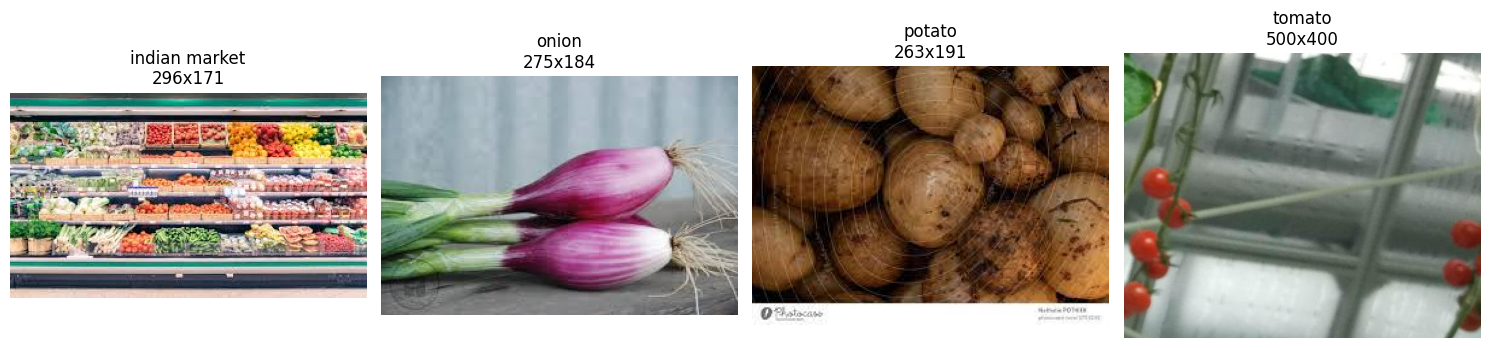

In [31]:
# Function to plot a grid of sample images from each class
def plot_sample_images(image_dict):
    num_classes = len(image_dict)
    fig, axes = plt.subplots(1, num_classes, figsize=(15, 5))

    for idx, (class_name, img) in enumerate(image_dict.items()):
        axes[idx].imshow(img)
        axes[idx].set_title(f'{class_name}\n{img.size[0]}x{img.size[1]}')
        axes[idx].axis('off')

    plt.tight_layout()
    plt.show()

# Plot sample images from the training set
plot_sample_images(image_dict)

### Plotting Distribution in each class in Train and Test Folders

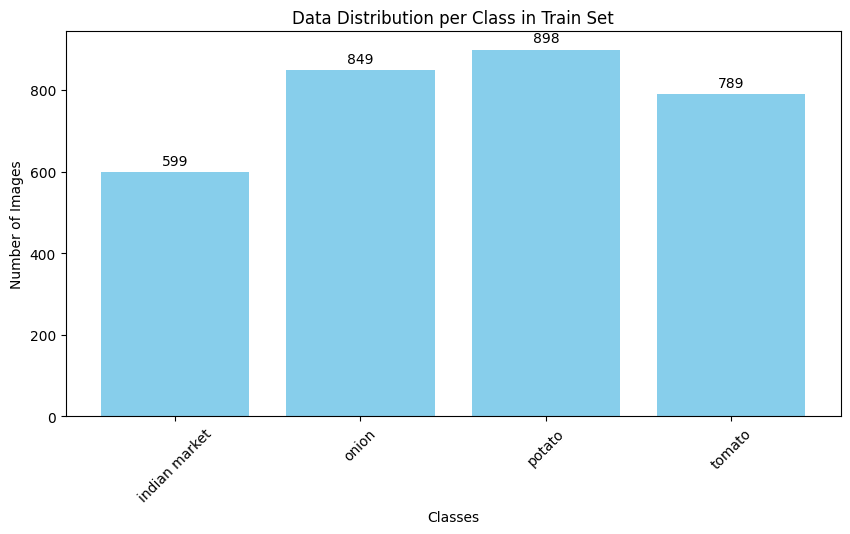

In [32]:
# Function to visualize the distribution of data per class in the train set with annotations
def plot_data_distribution(count_dict):
    classes = list(count_dict.keys())
    counts = list(count_dict.values())

    plt.figure(figsize=(10, 5))
    bars = plt.bar(classes, counts, color='skyblue')
    plt.xlabel('Classes')
    plt.ylabel('Number of Images')
    plt.title('Data Distribution per Class in Train Set')
    plt.xticks(rotation=45)

    # Annotate counts on the bars
    for bar in bars:
        height = bar.get_height()
        plt.annotate(f'{height}',
                     xy=(bar.get_x() + bar.get_width() / 2, height),
                     xytext=(0, 3),  # 3 points vertical offset
                     textcoords="offset points",
                     ha='center', va='bottom')

    plt.show()

# Plot the data distribution for the training set
plot_data_distribution(count_dict)

Image distribution is almost uniform across classes

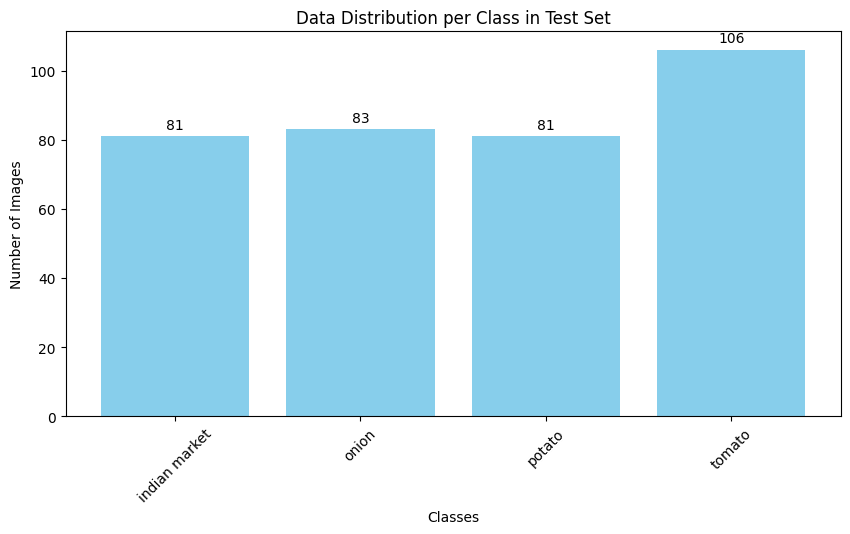

In [33]:
# Function to visualize the distribution of data per class in the test set with annotations
def plot_data_distribution(count_dict_test):
    classes = list(count_dict_test.keys())
    counts = list(count_dict_test.values())

    plt.figure(figsize=(10, 5))
    bars = plt.bar(classes, counts, color='skyblue')
    plt.xlabel('Classes')
    plt.ylabel('Number of Images')
    plt.title('Data Distribution per Class in Test Set')
    plt.xticks(rotation=45)

    # Annotate counts on the bars
    for bar in bars:
        height = bar.get_height()
        plt.annotate(f'{height}',
                     xy=(bar.get_x() + bar.get_width() / 2, height),
                     xytext=(0, 3),  # 3 points vertical offset
                     textcoords="offset points",
                     ha='center', va='bottom')

    plt.show()

# Plot the data distribution for the test set
plot_data_distribution(count_dict_test)

### Preparing data for Train,Validation and Test

In [39]:
# Parameters
batch_size = 16
img_height = 256
img_width = 256
seed = 123

# Create the training dataset
train_ds = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    validation_split=0.2,
    subset="training",
    seed=seed,
    image_size=(img_height, img_width),
    batch_size=batch_size,
    label_mode='categorical'
)

# Display the class names
class_names = train_ds.class_names
print(f"Class names: {class_names}")

Found 3135 files belonging to 4 classes.
Using 2508 files for training.
Class names: ['indian market', 'onion', 'potato', 'tomato']


In [40]:
# Create the validation dataset
val_ds = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    validation_split=0.2,
    subset="validation",
    seed=seed,
    image_size=(img_height, img_width),
    batch_size=batch_size,
    label_mode='categorical'
)

# Display the class names
class_names = val_ds.class_names
print(f"Class names: {class_names}")


Found 3135 files belonging to 4 classes.
Using 627 files for validation.
Class names: ['indian market', 'onion', 'potato', 'tomato']


In [41]:

# Create the testing dataset
test_ds = tf.keras.utils.image_dataset_from_directory(
    test_dir,
    image_size=(img_height, img_width),
    batch_size=batch_size,
    label_mode='categorical'
)

# Display the class names
class_names = test_ds.class_names
print(f"Class names: {class_names}")


Found 351 files belonging to 4 classes.
Class names: ['indian market', 'onion', 'potato', 'tomato']


### Building Simple Custom CNN Architecture

In [37]:
# Define the model
model = tf.keras.Sequential()

# Rescale the images
model.add(tf.keras.layers.Rescaling(1./255))

# Input layer
model.add(tf.keras.layers.InputLayer(input_shape=(256, 256, 3)))

# First convolutional block
model.add(tf.keras.layers.Conv2D(32, (3, 3), padding='same', activation='relu'))
model.add(tf.keras.layers.Conv2D(32, (3, 3), padding='same', activation='relu'))
model.add(tf.keras.layers.MaxPooling2D((2, 2)))

# Second convolutional block
model.add(tf.keras.layers.Conv2D(64, (3, 3), padding='same', activation='relu'))
model.add(tf.keras.layers.Conv2D(64, (3, 3), padding='same', activation='relu'))
model.add(tf.keras.layers.MaxPooling2D((2, 2)))

# Third convolutional block
model.add(tf.keras.layers.Conv2D(128, (3, 3), padding='same', activation='relu'))

# Global average pooling
model.add(tf.keras.layers.GlobalAveragePooling2D())

# Output layer
model.add(tf.keras.layers.Dense(4, activation='softmax'))

In [38]:
# Compile the model
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    loss=tf.keras.losses.CategoricalCrossentropy(),
    metrics=['accuracy', tf.keras.metrics.Recall(), tf.keras.metrics.Precision()]
)

#### Using Callbacks

In [39]:
from tensorflow.keras.callbacks import TensorBoard
import datetime

# Define the log directory for TensorBoard
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)

# Train the model
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=20,
    callbacks=[tensorboard_callback]
)

Epoch 1/20
157/157 [==============================] - 66s 270ms/step - loss: 1.3134 - accuracy: 0.3289 - recall_3: 0.0064 - precision_3: 0.8889 - val_loss: 1.0753 - val_accuracy: 0.6093 - val_recall_3: 0.1244 - val_precision_3: 0.7358
Epoch 2/20
157/157 [==============================] - 40s 254ms/step - loss: 0.8129 - accuracy: 0.6790 - recall_3: 0.4789 - precision_3: 0.8066 - val_loss: 0.7129 - val_accuracy: 0.6970 - val_recall_3: 0.6045 - val_precision_3: 0.7929
Epoch 3/20
157/157 [==============================] - 42s 265ms/step - loss: 0.6924 - accuracy: 0.7265 - recall_3: 0.6280 - precision_3: 0.8003 - val_loss: 0.6920 - val_accuracy: 0.7289 - val_recall_3: 0.6539 - val_precision_3: 0.7900
Epoch 4/20
157/157 [==============================] - 42s 268ms/step - loss: 0.6484 - accuracy: 0.7568 - recall_3: 0.6631 - precision_3: 0.8132 - val_loss: 0.6226 - val_accuracy: 0.7735 - val_recall_3: 0.6858 - val_precision_3: 0.8098
Epoch 5/20
157/157 [==============================] - 44s 27

#### Plotting Accuracy and Loss vs Epochs

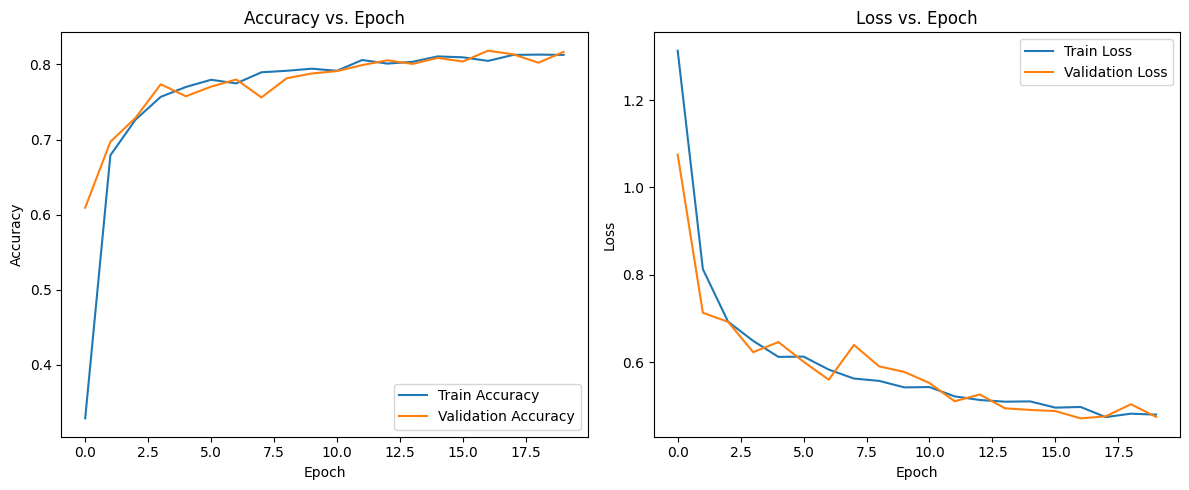

In [40]:

import matplotlib.pyplot as plt

def plot_metrics(history):
    # Plot accuracy
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Accuracy vs. Epoch')
    plt.legend()

    # Plot loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Loss vs. Epoch')
    plt.legend()

    plt.tight_layout()
    plt.show()

# Plot the metrics
plot_metrics(history)



In [41]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_3 (Rescaling)     (None, 256, 256, 3)       0         
                                                                 
 input_4 (InputLayer)        multiple                  0         
                                                                 
 conv2d_15 (Conv2D)          (None, 256, 256, 32)      896       
                                                                 
 conv2d_16 (Conv2D)          (None, 256, 256, 32)      9248      
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 128, 128, 32)     0         
 2D)                                                             
                                                                 
 conv2d_17 (Conv2D)          (None, 128, 128, 64)      18496     
                                                      

In [82]:
test_images = []

for folder in os.listdir(test_dir):
  for image in os.listdir(test_dir + '/' + folder):
    test_images.append(os.path.join(test_dir, folder, image))

In [43]:
def grid_test_model(model_name):

  fig = plt.figure(1, figsize=(17, 11))
  plt.axis('off')
  n = 0
  for i in range(8):
    n += 1

    img_0 = tf.keras.utils.load_img(random.choice(test_images))
    img_0 = tf.keras.utils.img_to_array(img_0)
    img_0 = tf.image.resize(img_0, (256, 256))
    img_1 = tf.expand_dims(img_0, axis = 0)

    pred = model_name.predict(img_1)
    predicted_label = tf.argmax(pred, 1).numpy().item()

    for item in pred :
      item = tf.round((item*100))

    plt.subplot(2, 4, n)
    plt.axis('off')
    plt.title(f'prediction : {class_names[predicted_label]}\n\n'
              f'{item[0]} % {class_names[0]}\n'
              f'{item[1]} % {class_names[1]}\n'
              f'{item[2]} % {class_names[2]}\n'
              f'{item[3]} % {class_names[3]}\n')
    plt.imshow(img_0/255)
  plt.show()

#### Testing the accuracy of our Custom CNN model

1/1 [==============================] - 0s 48ms/step


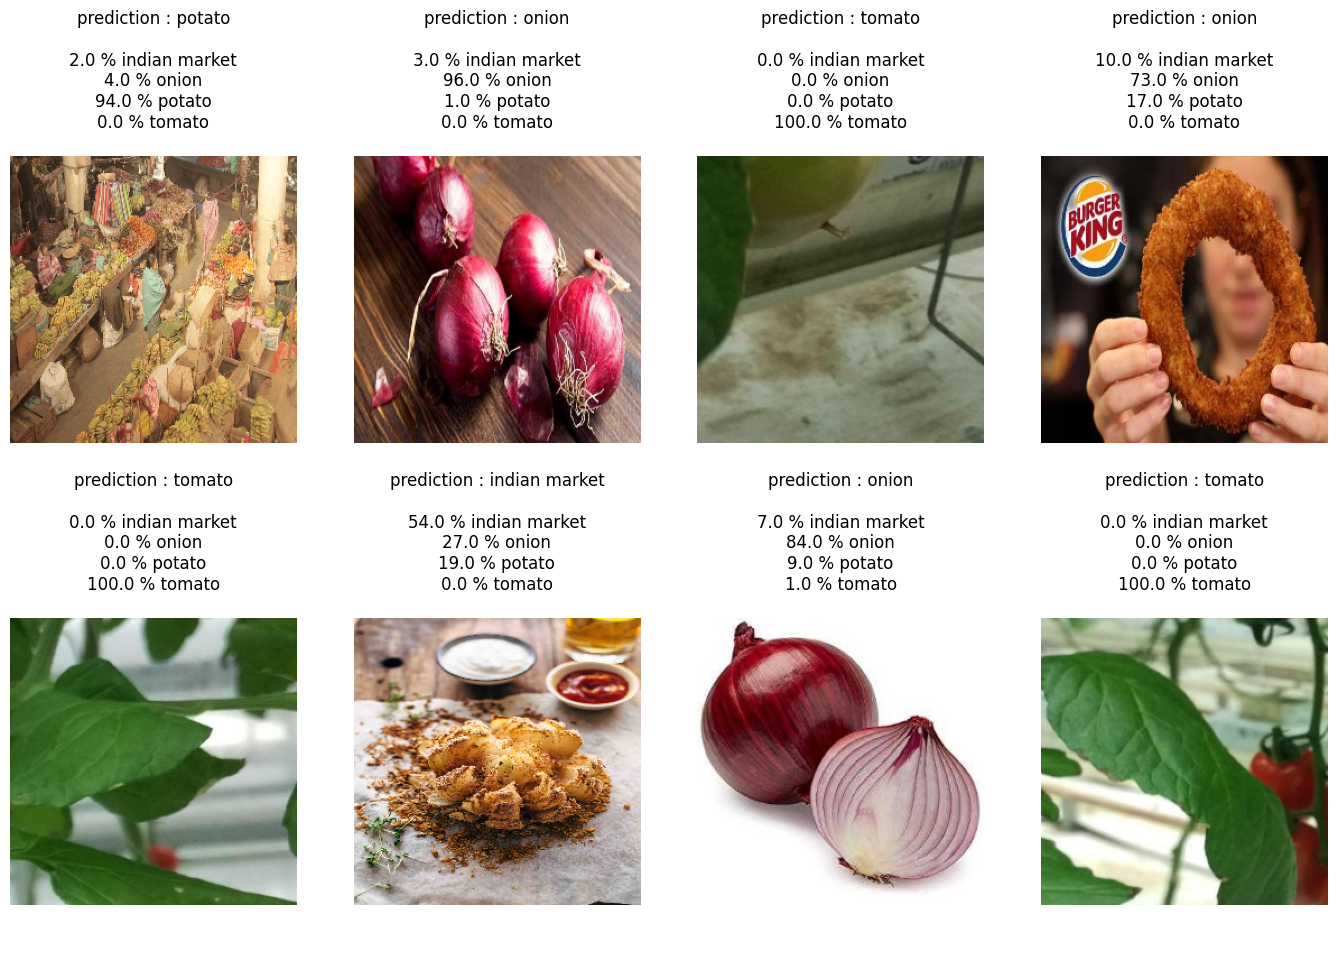

In [44]:
grid_test_model(model)

#### Class wise accuracy

In [45]:
# Initialize a dictionary to hold correct predictions and total samples for each class
class_correct = {class_name: 0 for class_name in class_names}
class_total = {class_name: 0 for class_name in class_names}

# Iterate over the test dataset and make predictions
for batch, labels in test_ds:
    predictions = model.predict(batch)
    predicted_classes = np.argmax(predictions, axis=1)
    true_classes = np.argmax(labels, axis=1)

    # Update the count of correct predictions and total samples for each class
    for true_class, predicted_class in zip(true_classes, predicted_classes):
        class_total[class_names[true_class]] += 1
        if true_class == predicted_class:
            class_correct[class_names[true_class]] += 1

# Calculate and print the accuracy for each class
for class_name in class_names:
    accuracy = class_correct[class_name] / class_total[class_name] if class_total[class_name] > 0 else 0
    print(f'Accuracy for class {class_name}: {accuracy:.2f}')

# Display the class-wise accuracy
for class_name in class_names:
    total = class_total[class_name]
    correct = class_correct[class_name]
    accuracy = (correct / total) * 100 if total > 0 else 0
    print(f'Class: {class_name}, Total: {total}, Correct: {correct}, Accuracy: {accuracy:.2f}%')

1/1 [==============================] - 1s 1s/step
Accuracy for class indian market: 0.75
Accuracy for class onion: 0.49
Accuracy for class potato: 0.86
Accuracy for class tomato: 0.98
Class: indian market, Total: 81, Correct: 61, Accuracy: 75.31%
Class: onion, Total: 83, Correct: 41, Accuracy: 49.40%
Class: potato, Total: 81, Correct: 70, Accuracy: 86.42%
Class: tomato, Total: 106, Correct: 104, Accuracy: 98.11%


#### Printing Confusion Matrix and Other Metrics

1/1 [==============================] - 0s 56ms/step


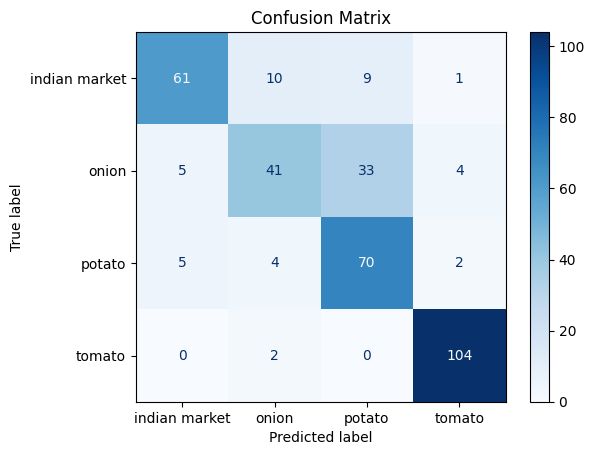

In [46]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Initialize lists to hold true and predicted labels
true_labels = []
predicted_labels = []

# Iterate over the test dataset and make predictions
for batch, labels in test_ds:
    predictions = model.predict(batch)
    predicted_classes = np.argmax(predictions, axis=1)
    true_classes = np.argmax(labels, axis=1)

    true_labels.extend(true_classes)
    predicted_labels.extend(predicted_classes)

# Calculate the confusion matrix
cm = confusion_matrix(true_labels, predicted_labels)

# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()


In [47]:
# Calculate metrics
loss, accuracy, precision, recall = model.evaluate(test_ds, verbose=0)

print(f"Loss: {loss:.4f}")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")

Loss: 0.4944
Accuracy: 0.7863
Precision: 0.7379
Recall: 0.8119


### Implementing 1st model with Augmentation,Batch Normalization and Dropout to avoid overfitting

In [48]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import TensorBoard
import datetime

# Data augmentation
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.2),
    layers.RandomContrast(0.2),
])

# Define the model
def create_model():
    model = models.Sequential()

    # Data augmentation layer
    model.add(data_augmentation)

    # Rescale the images
    model.add(layers.Rescaling(1./255))

    # Input layer
    model.add(layers.InputLayer(input_shape=(256, 256, 3)))

    # First convolutional block
    model.add(layers.Conv2D(32, (3, 3), padding='same', activation='relu'))
    model.add(layers.BatchNormalization())
    model.add(layers.Conv2D(32, (3, 3), padding='same', activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Dropout(0.25))

    # Second convolutional block
    model.add(layers.Conv2D(64, (3, 3), padding='same', activation='relu'))
    model.add(layers.BatchNormalization())
    model.add(layers.Conv2D(64, (3, 3), padding='same', activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Dropout(0.25))

    # Third convolutional block
    model.add(layers.Conv2D(128, (3, 3), padding='same', activation='relu'))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Dropout(0.25))

    # Global average pooling
    model.add(layers.GlobalAveragePooling2D())

    # Fully connected layer
    model.add(layers.Dense(128, activation='relu'))
    model.add(layers.BatchNormalization())
    model.add(layers.Dropout(0.5))

    # Output layer
    model.add(layers.Dense(4, activation='softmax'))

    return model

model = create_model()

# Compile the model
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    loss=tf.keras.losses.CategoricalCrossentropy(),
    metrics=['accuracy', tf.keras.metrics.Recall(), tf.keras.metrics.Precision()]
)

# Define the log directory for TensorBoard
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)

# Train the model
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=20,
    callbacks=[tensorboard_callback]
)

# To start TensorBoard and visualize the logs, use the following command in your terminal:
# tensorboard --logdir=logs/fit


Epoch 1/20
157/157 [==============================] - 114s 616ms/step - loss: 1.1064 - accuracy: 0.6184 - recall_4: 0.5578 - precision_4: 0.6624 - val_loss: 2.4275 - val_accuracy: 0.2663 - val_recall_4: 0.2663 - val_precision_4: 0.2663
Epoch 2/20
157/157 [==============================] - 97s 613ms/step - loss: 0.8349 - accuracy: 0.7033 - recall_4: 0.6575 - precision_4: 0.7345 - val_loss: 4.2072 - val_accuracy: 0.2663 - val_recall_4: 0.2663 - val_precision_4: 0.2663
Epoch 3/20
157/157 [==============================] - 98s 622ms/step - loss: 0.7607 - accuracy: 0.7209 - recall_4: 0.6786 - precision_4: 0.7602 - val_loss: 3.5498 - val_accuracy: 0.4067 - val_recall_4: 0.4067 - val_precision_4: 0.4093
Epoch 4/20
157/157 [==============================] - 102s 645ms/step - loss: 0.7560 - accuracy: 0.7245 - recall_4: 0.6890 - precision_4: 0.7616 - val_loss: 3.0086 - val_accuracy: 0.4737 - val_recall_4: 0.4705 - val_precision_4: 0.4735
Epoch 5/20
157/157 [==============================] - 99s 

1/1 [==============================] - 0s 50ms/step


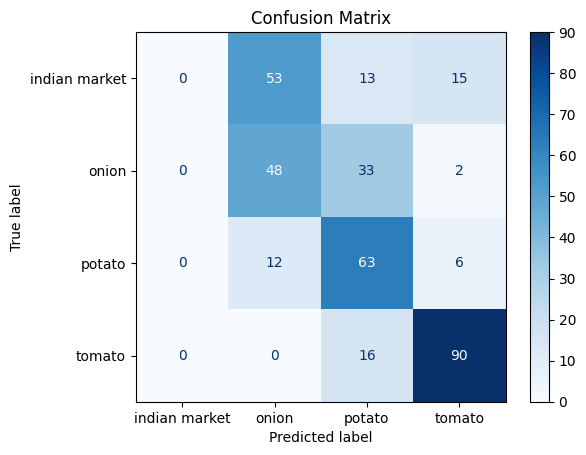

Loss: 2.1668
Accuracy: 0.5726
Precision: 0.5923
Recall: 0.5670


In [49]:
# Initialize lists to hold true and predicted labels
true_labels = []
predicted_labels = []

# Iterate over the test dataset and make predictions
for batch, labels in test_ds:
    predictions = model.predict(batch)
    predicted_classes = np.argmax(predictions, axis=1)
    true_classes = np.argmax(labels, axis=1)

    true_labels.extend(true_classes)
    predicted_labels.extend(predicted_classes)

# Calculate the confusion matrix
cm = confusion_matrix(true_labels, predicted_labels)

# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

# Calculate metrics
loss, accuracy, recall, precision = model.evaluate(test_ds, verbose=0)

print(f"Loss: {loss:.4f}")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")

Hiding Warnings and logging as it became cluttered

In [51]:
import warnings
warnings.filterwarnings('ignore')


In [53]:
import os
import warnings
import logging

# Suppress TensorFlow logging messages
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'  # Suppress TensorFlow logging messages (INFO, WARNING, and ERROR)

# Suppress warnings using the warnings module
warnings.filterwarnings('ignore', category=FutureWarning)
warnings.filterwarnings('ignore', category=DeprecationWarning)
warnings.filterwarnings('ignore', message=r'Using a while_loop for converting.*')  # Specific pattern

# Suppress TensorFlow's internal logging
logging.getLogger('tensorflow').setLevel(logging.ERROR)

#### Implementing 2nd model with Different Augmentation,Batch Normalization and Dropout

In [55]:


# Define data augmentation
data_aug = tf.keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.2),
    layers.RandomTranslation(height_factor=0.2, width_factor=0.2)
])

# Define the model
def create_model_aug():
    model = models.Sequential([
        # Data augmentation layer
        data_aug,
        
        # Rescale the images
        layers.Rescaling(1./255),
        
        # Input layer
        layers.InputLayer(input_shape=(256, 256, 3)),
        
        # First convolutional block
        layers.Conv2D(32, (3, 3), padding='same', activation='relu'),
        layers.Conv2D(32, (3, 3), padding='same', activation='relu'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        
        # Second convolutional block
        layers.Conv2D(64, (3, 3), padding='same', activation='relu'),
        layers.Conv2D(64, (3, 3), padding='same', activation='relu'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        
        # Third convolutional block
        layers.Conv2D(128, (3, 3), padding='same', activation='relu'),
        layers.BatchNormalization(),
        layers.GlobalAveragePooling2D(),
        layers.Dropout(0.2),
        
        # Output layer
        layers.Dense(4, activation='softmax')
    ])
    
    # Compile the model
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
        loss=tf.keras.losses.CategoricalCrossentropy(),
        metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()]
    )
    
    return model




In [56]:
# Create the model
model_aug = create_model_aug()

# Define callbacks
log_dir_2 = "logs/Custom_CNN_aug/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_cb = TensorBoard(log_dir=log_dir_2, histogram_freq=1)

checkpoint_cb = ModelCheckpoint("CNN_best.h5", save_best_only=True)

early_stopping_cb = EarlyStopping(
    monitor='val_loss', patience=5, restore_best_weights=True
)

# Train the model
history = model_aug.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10,
    callbacks=[tensorboard_cb, checkpoint_cb, early_stopping_cb]
)

# To start TensorBoard and visualize the logs, use the following command in your terminal:
# tensorboard --logdir=logs/Custom_CNN_aug

Epoch 1/10
157/157 [==============================] - 84s 471ms/step - loss: 0.7490 - accuracy: 0.7101 - precision_5: 0.7998 - recall_5: 0.5686 - val_loss: 1.4894 - val_accuracy: 0.2711 - val_precision_5: 0.2919 - val_recall_5: 0.2695
Epoch 2/10
157/157 [==============================] - 78s 498ms/step - loss: 0.6052 - accuracy: 0.7675 - precision_5: 0.8237 - recall_5: 0.6986 - val_loss: 1.7997 - val_accuracy: 0.2711 - val_precision_5: 0.2711 - val_recall_5: 0.2711
Epoch 3/10
157/157 [==============================] - 85s 543ms/step - loss: 0.5563 - accuracy: 0.7843 - precision_5: 0.8358 - recall_5: 0.7225 - val_loss: 1.1529 - val_accuracy: 0.4003 - val_precision_5: 0.4816 - val_recall_5: 0.3333
Epoch 4/10
157/157 [==============================] - 81s 512ms/step - loss: 0.5373 - accuracy: 0.7990 - precision_5: 0.8459 - recall_5: 0.7532 - val_loss: 0.5824 - val_accuracy: 0.7895 - val_precision_5: 0.8660 - val_recall_5: 0.6906
Epoch 5/10
157/157 [==============================] - 81s 51

#### Plotting Confusion Matrix and other metrics for CNN(modified)

1/1 [==============================] - 0s 51ms/step


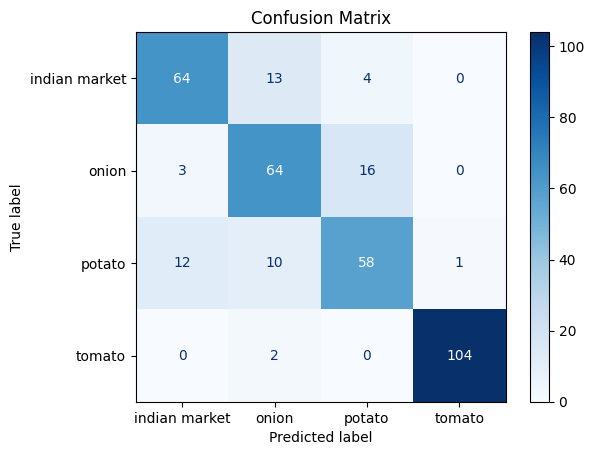

Loss: 0.4791
Accuracy: 0.8262
Precision: 0.8589
Recall: 0.7806


In [57]:
# Initialize lists to hold true and predicted labels
true_labels = []
predicted_labels = []

# Iterate over the test dataset and make predictions
for batch, labels in test_ds:
    predictions = model_aug.predict(batch)
    predicted_classes = np.argmax(predictions, axis=1)
    true_classes = np.argmax(labels, axis=1)
    
    true_labels.extend(true_classes)
    predicted_labels.extend(predicted_classes)

# Calculate the confusion matrix
cm = confusion_matrix(true_labels, predicted_labels)

# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

# Calculate metrics
loss, accuracy, precision, recall = model_aug.evaluate(test_ds, verbose=0)

print(f"Loss: {loss:.4f}")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")

#### Checking Model Performance of Custom CNN(modified)

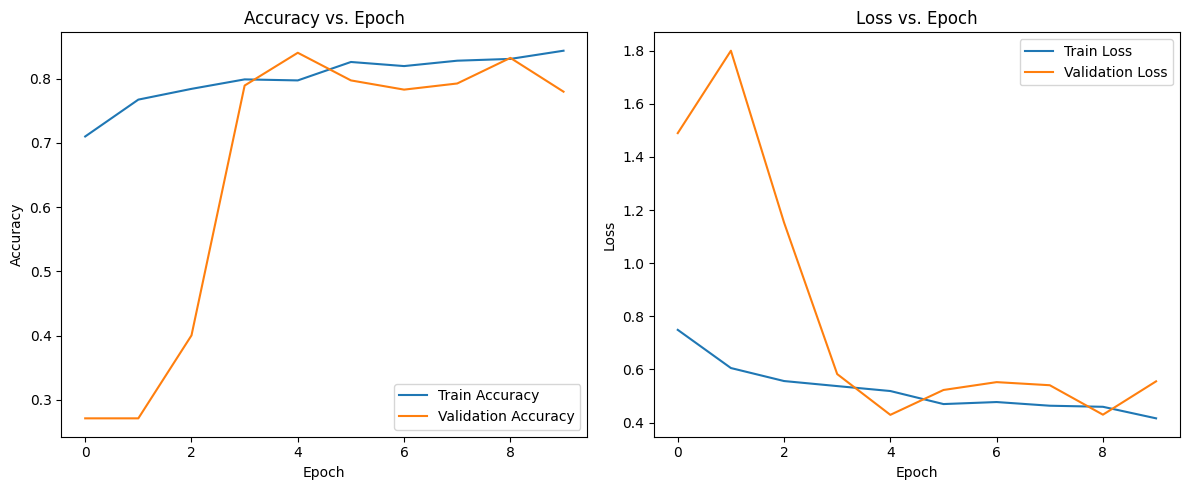

In [58]:
import matplotlib.pyplot as plt

def plot_metrics(history):
    # Plot accuracy
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Accuracy vs. Epoch')
    plt.legend()

    # Plot loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Loss vs. Epoch')
    plt.legend()

    plt.tight_layout()
    plt.show()

# Plot the metrics for the new model
plot_metrics(history)


In [59]:
# Initialize dictionaries to hold correct predictions and total samples for each class
class_correct = {class_name: 0 for class_name in class_names}
class_total = {class_name: 0 for class_name in class_names}

# Iterate over the test dataset and make predictions
for batch, labels in test_ds:
    predictions = model_aug.predict(batch)
    predicted_classes = np.argmax(predictions, axis=1)
    true_classes = np.argmax(labels, axis=1)

    # Update the count of correct predictions and total samples for each class
    for true_class, predicted_class in zip(true_classes, predicted_classes):
        class_total[class_names[true_class]] += 1
        if true_class == predicted_class:
            class_correct[class_names[true_class]] += 1

# Calculate and print the accuracy for each class
for class_name in class_names:
    accuracy = class_correct[class_name] / class_total[class_name] if class_total[class_name] > 0 else 0
    print(f'Accuracy for class {class_name}: {accuracy:.2f}')

# Display the class-wise accuracy
for class_name in class_names:
    total = class_total[class_name]
    correct = class_correct[class_name]
    accuracy = (correct / total) * 100 if total > 0 else 0
    print(f'Class: {class_name}, Total: {total}, Correct: {correct}, Accuracy: {accuracy:.2f}%')


1/1 [==============================] - 0s 47ms/step
Accuracy for class indian market: 0.79
Accuracy for class onion: 0.77
Accuracy for class potato: 0.72
Accuracy for class tomato: 0.98
Class: indian market, Total: 81, Correct: 64, Accuracy: 79.01%
Class: onion, Total: 83, Correct: 64, Accuracy: 77.11%
Class: potato, Total: 81, Correct: 58, Accuracy: 71.60%
Class: tomato, Total: 106, Correct: 104, Accuracy: 98.11%


# Transfer Learning

### Choosing 128x128 as image size because GPU ran out of memory

In [49]:
# Parameters
batch_size = 8
img_height = 128
img_width = 128
seed = 124

# Create the training dataset
train_dsvgg = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    validation_split=0.2,
    subset="training",
    seed=seed,
    image_size=(img_height, img_width),
    batch_size=batch_size,
    label_mode='categorical'
)

# Display the class names
class_names = train_dsvgg.class_names
print(f"Class names: {class_names}")

Found 3135 files belonging to 4 classes.
Using 2508 files for training.
Class names: ['indian market', 'onion', 'potato', 'tomato']


In [50]:
# Create the validation dataset
val_dsvgg = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    validation_split=0.2,
    subset="validation",
    seed=seed,
    image_size=(img_height, img_width),
    batch_size=batch_size,
    label_mode='categorical'
)

# Display the class names
class_names = val_dsvgg.class_names
print(f"Class names: {class_names}")


Found 3135 files belonging to 4 classes.
Using 627 files for validation.
Class names: ['indian market', 'onion', 'potato', 'tomato']


In [51]:

# Create the testing dataset
test_dsvgg = tf.keras.utils.image_dataset_from_directory(
    test_dir,
    image_size=(img_height, img_width),
    batch_size=batch_size,
    label_mode='categorical'
)

# Display the class names
class_names = test_dsvgg.class_names
print(f"Class names: {class_names}")


Found 351 files belonging to 4 classes.
Class names: ['indian market', 'onion', 'potato', 'tomato']


#### Creating VGG19 base model

In [53]:

# load base model
base_model = tf.keras.applications.vgg19.VGG19(input_shape=(128, 128, 3), include_top = False)

In [54]:
# append classification layer
model_1 = base_model.output


model_1 = tf.keras.Sequential([
        # Normalizing 0-255 into 0 to 1
        tf.keras.layers.Rescaling(1./255),
        # Input layer with specified input shape
        tf.keras.layers.Input(shape=(128, 128, 3)),
        base_model,
        tf.keras.layers.GlobalAveragePooling2D(),
        tf.keras.layers.Dropout(rate=0.1),
        tf.keras.layers.Dense(4, activation='softmax', dtype='float32')  # Ensure final layer is float32
    ])

In [55]:
model_1.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = 1e-4),
              loss = tf.keras.losses.CategoricalCrossentropy(),
              metrics = ['accuracy', 'Precision', 'Recall'])

In [56]:
import datetime
# Define callbacks
log_dir_vgg19 = "logs/VGG19/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_cb = TensorBoard(log_dir=log_dir_vgg19, histogram_freq=1)

checkpoint_cb = ModelCheckpoint("VGG19_best.h5", save_best_only=True)

early_stopping_cb = EarlyStopping(
    monitor='val_loss', patience=5, restore_best_weights=True
)


In [57]:
history_1 = model_1.fit(train_dsvgg, validation_data = val_dsvgg, 
                        epochs = 10, 
                        callbacks=[tensorboard_cb, checkpoint_cb, early_stopping_cb])

Epoch 1/10
314/314 [==============================] - 62s 172ms/step - loss: 0.6795 - accuracy: 0.7265 - precision: 0.7928 - recall: 0.6467 - val_loss: 0.2814 - val_accuracy: 0.8868 - val_precision: 0.8934 - val_recall: 0.8820
Epoch 2/10
314/314 [==============================] - 55s 174ms/step - loss: 0.4312 - accuracy: 0.8465 - precision: 0.8638 - recall: 0.8246 - val_loss: 0.2680 - val_accuracy: 0.9059 - val_precision: 0.9123 - val_recall: 0.8963
Epoch 3/10
314/314 [==============================] - 56s 178ms/step - loss: 0.3033 - accuracy: 0.8852 - precision: 0.8957 - recall: 0.8764 - val_loss: 0.4343 - val_accuracy: 0.8485 - val_precision: 0.8657 - val_recall: 0.8325
Epoch 4/10
314/314 [==============================] - 59s 186ms/step - loss: 0.2762 - accuracy: 0.9027 - precision: 0.9084 - recall: 0.8935 - val_loss: 0.2001 - val_accuracy: 0.9219 - val_precision: 0.9364 - val_recall: 0.9155
Epoch 5/10
314/314 [==============================] - 71s 225ms/step - loss: 0.1967 - accura

#### Checking Performance of VGG19

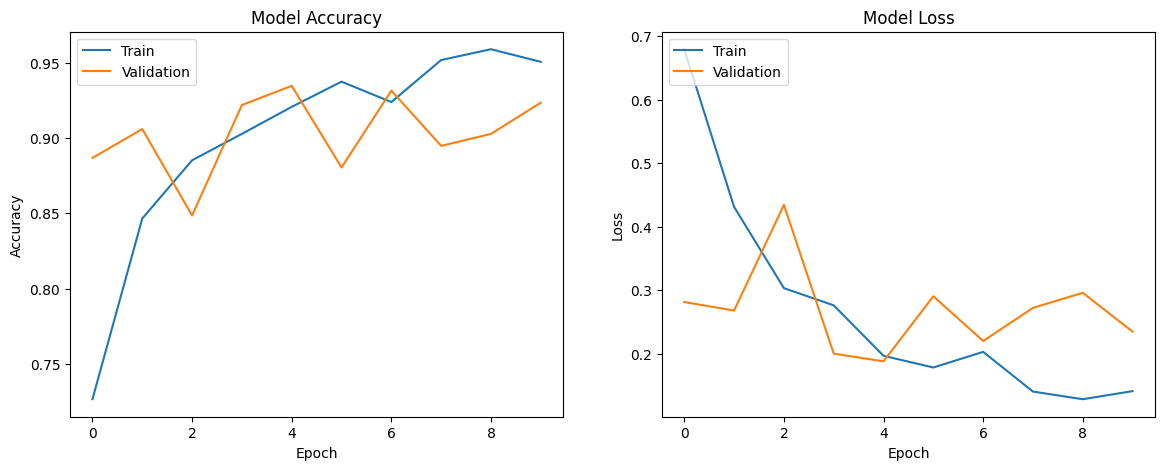

In [59]:
def plot_training_history(history):
    # Plot training & validation accuracy values
    plt.figure(figsize=(14, 5))
    
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    
    # Plot training & validation loss values
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    
    plt.show()

# Assuming history_vgg19 contains the training history of the VGG19 model
plot_training_history(history_1)

#### Plotting Confusion Matrix and printing Classification Metrics for VGG19

In [60]:
class_names = test_dsvgg.class_names

# Evaluate the model on the test set
loss, accuracy, precision, recall = model_1.evaluate(test_dsvgg)
print(f"Overall Loss: {loss:.4f}")
print(f"Overall Accuracy: {accuracy:.4f}")
print(f"Overall Precision: {precision:.4f}")
print(f"Overall Recall: {recall:.4f}")

# Predict on the test set
y_true = []
y_pred = []

for images, labels in test_dsvgg:
    preds = model_1.predict(images)
    y_true.extend(tf.argmax(labels, axis=1).numpy())
    y_pred.extend(tf.argmax(preds, axis=1).numpy())

# Calculate confusion matrix
cm = confusion_matrix(y_true, y_pred)
print("Confusion Matrix:\n", cm)

# Print classification report for detailed metrics per class
report = classification_report(y_true, y_pred, target_names=class_names)
print("Classification Report:\n", report)

# Calculate class-wise accuracy
class_total = {class_name: 0 for class_name in class_names}
class_correct = {class_name: 0 for class_name in class_names}

for true_class, predicted_class in zip(y_true, y_pred):
    class_total[class_names[true_class]] += 1
    if true_class == predicted_class:
        class_correct[class_names[true_class]] += 1

# Print class-wise accuracy
for class_name in class_names:
    accuracy = class_correct[class_name] / class_total[class_name] if class_total[class_name] > 0 else 0
    print(f'Accuracy for class {class_name}: {accuracy:.2f}')

44/44 [==============================] - 4s 71ms/step - loss: 0.1846 - accuracy: 0.9288 - precision: 0.9556 - recall: 0.9202
Overall Loss: 0.1846
Overall Accuracy: 0.9288
Overall Precision: 0.9556
Overall Recall: 0.9202
1/1 [==============================] - 0s 43ms/step
Confusion Matrix:
 [[ 72   8   1   0]
 [  0  78   4   1]
 [  4   7  70   0]
 [  0   0   0 106]]
Classification Report:
                precision    recall  f1-score   support

indian market       0.95      0.89      0.92        81
        onion       0.84      0.94      0.89        83
       potato       0.93      0.86      0.90        81
       tomato       0.99      1.00      1.00       106

     accuracy                           0.93       351
    macro avg       0.93      0.92      0.92       351
 weighted avg       0.93      0.93      0.93       351

Accuracy for class indian market: 0.89
Accuracy for class onion: 0.94
Accuracy for class potato: 0.86
Accuracy for class tomato: 1.00


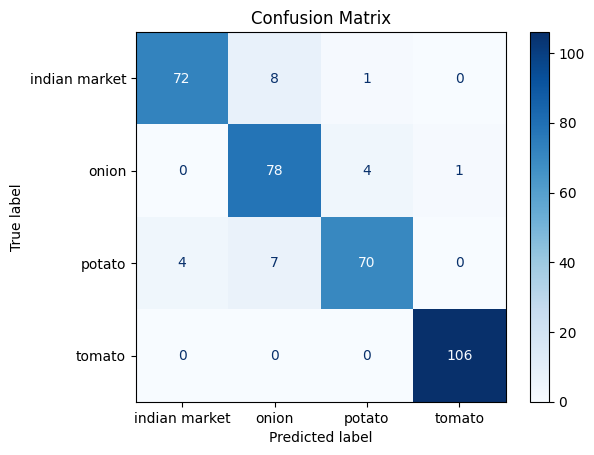

In [63]:
from sklearn.metrics import confusion_matrix, classification_report,ConfusionMatrixDisplay
# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

# ResNet 50

#### Creating base model for RESNET 50,building architecture ,compiling ang training

In [64]:
# load base model
base_model_2 = tf.keras.applications.resnet50.ResNet50(input_shape=(128, 128, 3), include_top = False)

94765736/94765736 [==============================] - 8s 0us/step


In [65]:
# append classification layer
model_2 = base_model_2.output

model_2 = tf.keras.Sequential([
            #Normalizing 0-255 into 0 to 1
            tf.keras.layers.Rescaling(1./255),
            tf.keras.layers.Input(shape=(128, 128, 3)),
            base_model_2,
            tf.keras.layers.GlobalAveragePooling2D(),
            tf.keras.layers.Dropout(rate = 0.1),
            tf.keras.layers.Dense(4, activation = 'softmax')
        ])

In [66]:
model_2.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = 1e-4),
              loss = tf.keras.losses.CategoricalCrossentropy(),
              metrics = ['accuracy', 'Precision', 'Recall'])

In [67]:
log_dir_resnet = "logs/ResNet/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

tensorboard_cb = tf.keras.callbacks.TensorBoard(log_dir=log_dir_resnet, histogram_freq=1)

checkpoint_cb = tf.keras.callbacks.ModelCheckpoint("ResNet.h5", save_best_only=True)

early_stopping_cb = tf.keras.callbacks.EarlyStopping(
    monitor = 'val_loss', patience = 5, restore_best_weights=True
)

In [69]:
history_2 = model_2.fit(train_dsvgg, validation_data = val_dsvgg, epochs = 10, callbacks=[tensorboard_cb, checkpoint_cb, early_stopping_cb])


Epoch 1/10
314/314 [==============================] - 59s 151ms/step - loss: 0.3706 - accuracy: 0.8624 - precision: 0.8837 - recall: 0.8361 - val_loss: 3.3625 - val_accuracy: 0.2201 - val_precision: 0.2181 - val_recall: 0.1802
Epoch 2/10
314/314 [==============================] - 46s 145ms/step - loss: 0.1420 - accuracy: 0.9494 - precision: 0.9548 - recall: 0.9438 - val_loss: 1.1848 - val_accuracy: 0.5439 - val_precision: 0.6066 - val_recall: 0.4721
Epoch 3/10
314/314 [==============================] - 47s 147ms/step - loss: 0.0837 - accuracy: 0.9733 - precision: 0.9752 - recall: 0.9721 - val_loss: 0.2010 - val_accuracy: 0.9394 - val_precision: 0.9407 - val_recall: 0.9362
Epoch 4/10
314/314 [==============================] - 48s 151ms/step - loss: 0.0727 - accuracy: 0.9789 - precision: 0.9804 - recall: 0.9781 - val_loss: 0.1765 - val_accuracy: 0.9426 - val_precision: 0.9425 - val_recall: 0.9410
Epoch 5/10
314/314 [==============================] - 45s 142ms/step - loss: 0.0863 - accura

#### CHecking RESNET model performance,metrics and confusion Matrix

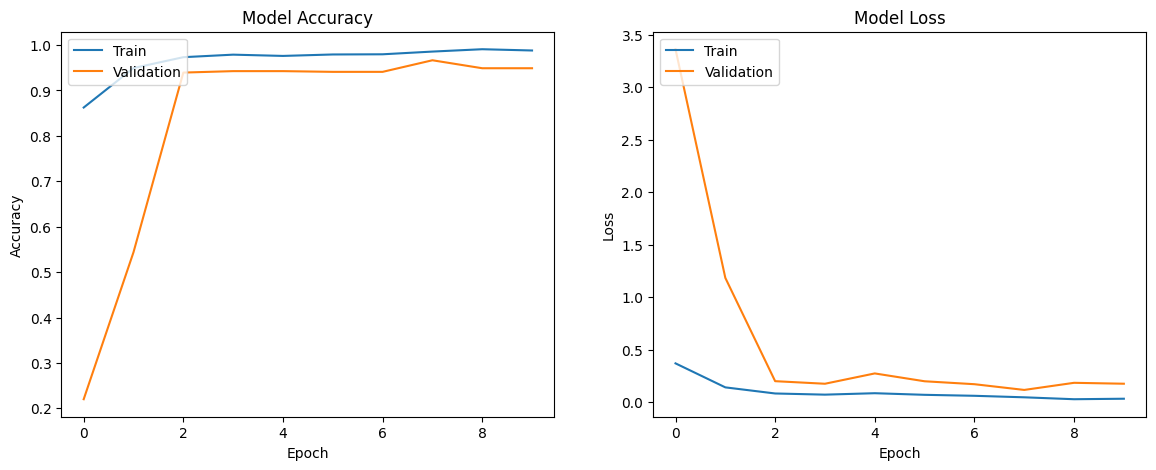

In [70]:
plot_training_history(history_2)

44/44 [==============================] - 2s 35ms/step - loss: 0.2338 - accuracy: 0.9288 - precision: 0.9288 - recall: 0.9288
Overall Loss: 0.2338
Overall Accuracy: 0.9288
Overall Precision: 0.9288
Overall Recall: 0.9288
1/1 [==============================] - 0s 45ms/step
Classification Report:
                precision    recall  f1-score   support

indian market       0.95      0.89      0.92        81
        onion       0.84      0.94      0.89        83
       potato       0.93      0.86      0.90        81
       tomato       0.99      1.00      1.00       106

     accuracy                           0.93       351
    macro avg       0.93      0.92      0.92       351
 weighted avg       0.93      0.93      0.93       351

Accuracy for class indian market: 0.89
Accuracy for class onion: 0.94
Accuracy for class potato: 0.86
Accuracy for class tomato: 1.00


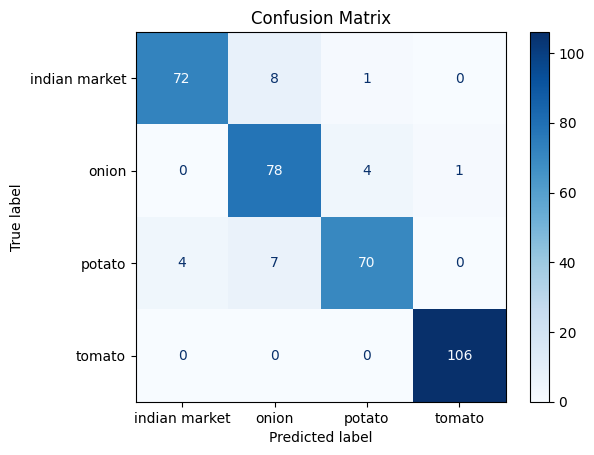

In [71]:
class_names = test_dsvgg.class_names

# Evaluate the model on the test set
loss, accuracy, precision, recall = model_2.evaluate(test_dsvgg)
print(f"Overall Loss: {loss:.4f}")
print(f"Overall Accuracy: {accuracy:.4f}")
print(f"Overall Precision: {precision:.4f}")
print(f"Overall Recall: {recall:.4f}")

# Predict on the test set
y_true = []
y_pred = []

for images, labels in test_dsvgg:
    preds = model_1.predict(images)
    y_true.extend(tf.argmax(labels, axis=1).numpy())
    y_pred.extend(tf.argmax(preds, axis=1).numpy())

# Calculate confusion matrix
cm = confusion_matrix(y_true, y_pred)
# print("Confusion Matrix:\n", cm)

# Print classification report for detailed metrics per class
report = classification_report(y_true, y_pred, target_names=class_names)
print("Classification Report:\n", report)

# Calculate class-wise accuracy
class_total = {class_name: 0 for class_name in class_names}
class_correct = {class_name: 0 for class_name in class_names}

for true_class, predicted_class in zip(y_true, y_pred):
    class_total[class_names[true_class]] += 1
    if true_class == predicted_class:
        class_correct[class_names[true_class]] += 1

# Print class-wise accuracy
for class_name in class_names:
    accuracy = class_correct[class_name] / class_total[class_name] if class_total[class_name] > 0 else 0
    print(f'Accuracy for class {class_name}: {accuracy:.2f}')

from sklearn.metrics import confusion_matrix, classification_report,ConfusionMatrixDisplay
# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

# MobileNet

#### Creating base model for MobileNet,building architecture ,compiling ang training

In [72]:
# load base model
base_model_3 = tf.keras.applications.mobilenet.MobileNet(input_shape=(128, 128, 3), include_top = False)

17225924/17225924 [==============================] - 3s 0us/step


In [73]:
# append classification layer
model_3 = base_model_3.output

model_3 = tf.keras.Sequential([
            #Normalizing 0-255 into 0 to 1
            tf.keras.layers.Rescaling(1./255),
            tf.keras.layers.Input(shape=(128, 128, 3)),
            base_model_3,
            tf.keras.layers.GlobalAveragePooling2D(),
            tf.keras.layers.Dropout(rate = 0.1),
            tf.keras.layers.Dense(4, activation = 'softmax')
        ])

In [74]:
log_dir_mobilenet = "logs/MobileNet/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

tensorboard_cb = tf.keras.callbacks.TensorBoard(log_dir=log_dir_mobilenet, histogram_freq=1)

checkpoint_cb = tf.keras.callbacks.ModelCheckpoint("MobileNet.h5", save_best_only=True)

early_stopping_cb = tf.keras.callbacks.EarlyStopping(
    monitor = 'val_loss', patience = 5, restore_best_weights=True
)

In [75]:
model_3.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = 1e-4),
              loss = tf.keras.losses.CategoricalCrossentropy(),
              metrics = ['accuracy', 'Precision', 'Recall'])

In [76]:
history_3 = model_3.fit(train_dsvgg, validation_data = val_dsvgg, epochs = 20, callbacks=[tensorboard_cb, checkpoint_cb, early_stopping_cb])

Epoch 1/20
314/314 [==============================] - 23s 59ms/step - loss: 0.3997 - accuracy: 0.8557 - precision: 0.8727 - recall: 0.8365 - val_loss: 0.1577 - val_accuracy: 0.9569 - val_precision: 0.9582 - val_recall: 0.9506
Epoch 2/20
314/314 [==============================] - 17s 53ms/step - loss: 0.1574 - accuracy: 0.9470 - precision: 0.9536 - recall: 0.9422 - val_loss: 0.1776 - val_accuracy: 0.9378 - val_precision: 0.9408 - val_recall: 0.9378
Epoch 3/20
314/314 [==============================] - 17s 55ms/step - loss: 0.1015 - accuracy: 0.9649 - precision: 0.9691 - recall: 0.9613 - val_loss: 0.0749 - val_accuracy: 0.9681 - val_precision: 0.9681 - val_recall: 0.9681
Epoch 4/20
314/314 [==============================] - 17s 53ms/step - loss: 0.0730 - accuracy: 0.9741 - precision: 0.9771 - recall: 0.9705 - val_loss: 0.0898 - val_accuracy: 0.9681 - val_precision: 0.9696 - val_recall: 0.9681
Epoch 5/20
314/314 [==============================] - 17s 54ms/step - loss: 0.0669 - accuracy: 0

#### Checking performance of MobileNet,plotting confusion Matrix and printing other metrics

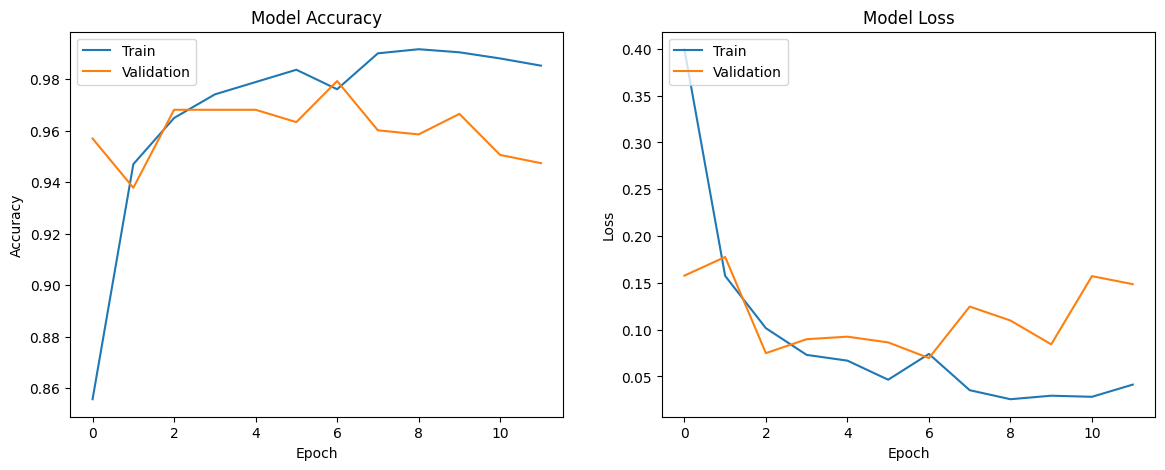

In [78]:
plot_training_history(history_3)

44/44 [==============================] - 1s 21ms/step - loss: 0.2499 - accuracy: 0.9316 - precision: 0.9370 - recall: 0.9316
Overall Loss: 0.2499
Overall Accuracy: 0.9316
Overall Precision: 0.9370
Overall Recall: 0.9316
1/1 [==============================] - 0s 33ms/step
Classification Report:
                precision    recall  f1-score   support

indian market       1.00      0.88      0.93        81
        onion       0.80      0.95      0.87        83
       potato       0.95      0.88      0.91        81
       tomato       1.00      1.00      1.00       106

     accuracy                           0.93       351
    macro avg       0.94      0.93      0.93       351
 weighted avg       0.94      0.93      0.93       351

Accuracy for class indian market: 0.88
Accuracy for class onion: 0.95
Accuracy for class potato: 0.88
Accuracy for class tomato: 1.00


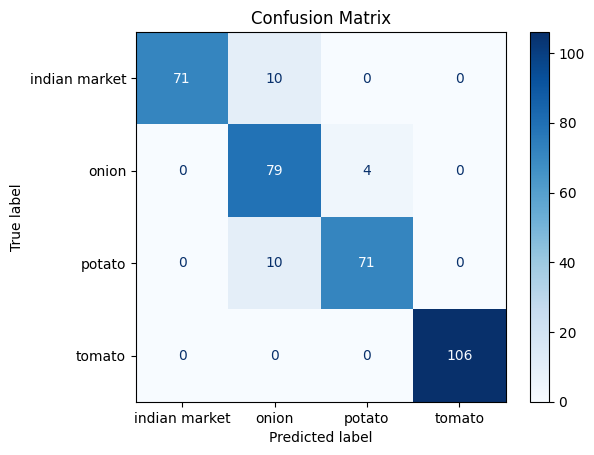

In [77]:
class_names = test_dsvgg.class_names

# Evaluate the model on the test set
loss, accuracy, precision, recall = model_3.evaluate(test_dsvgg)
print(f"Overall Loss: {loss:.4f}")
print(f"Overall Accuracy: {accuracy:.4f}")
print(f"Overall Precision: {precision:.4f}")
print(f"Overall Recall: {recall:.4f}")

# Predict on the test set
y_true = []
y_pred = []

for images, labels in test_dsvgg:
    preds = model_3.predict(images)
    y_true.extend(tf.argmax(labels, axis=1).numpy())
    y_pred.extend(tf.argmax(preds, axis=1).numpy())

# Calculate confusion matrix
cm = confusion_matrix(y_true, y_pred)
# print("Confusion Matrix:\n", cm)

# Print classification report for detailed metrics per class
report = classification_report(y_true, y_pred, target_names=class_names)
print("Classification Report:\n", report)

# Calculate class-wise accuracy
class_total = {class_name: 0 for class_name in class_names}
class_correct = {class_name: 0 for class_name in class_names}

for true_class, predicted_class in zip(y_true, y_pred):
    class_total[class_names[true_class]] += 1
    if true_class == predicted_class:
        class_correct[class_names[true_class]] += 1

# Print class-wise accuracy
for class_name in class_names:
    accuracy = class_correct[class_name] / class_total[class_name] if class_total[class_name] > 0 else 0
    print(f'Accuracy for class {class_name}: {accuracy:.2f}')

from sklearn.metrics import confusion_matrix, classification_report,ConfusionMatrixDisplay
# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

##                                          Comparision of all models:

| Model | Test Acc| Train Acc
| --- | --- | ---|
| Custom CNN | 78% | 81% |
| CNN Modified |  82%| 84% |
| VGG19 | 93% | 95% |
| ResNet50 | 95% | 99% |
| MobileNet | 94% | 99% |


#### Model Summary of VGG 19

In [79]:
model_1.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_6 (Rescaling)     (None, 128, 128, 3)       0         
                                                                 
 input_13 (InputLayer)       multiple                  0         
                                                                 
 vgg19 (Functional)          (None, 4, 4, 512)         20024384  
                                                                 
 global_average_pooling2d_5   (None, 512)              0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dropout_5 (Dropout)         (None, 512)               0         
                                                                 
 dense_7 (Dense)             (None, 4)                 2052      
                                                      

#### Model Summary of ResNet50

In [85]:
model_2.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_7 (Rescaling)     (None, 128, 128, 3)       0         
                                                                 
 input_15 (InputLayer)       multiple                  0         
                                                                 
 resnet50 (Functional)       (None, 4, 4, 2048)        23587712  
                                                                 
 global_average_pooling2d_6   (None, 2048)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dropout_6 (Dropout)         (None, 2048)              0         
                                                                 
 dense_8 (Dense)             (None, 4)                 8196      
                                                      

#### Model Summary of MobileNet

In [86]:
model_3.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_8 (Rescaling)     (None, 128, 128, 3)       0         
                                                                 
 input_17 (InputLayer)       multiple                  0         
                                                                 
 mobilenet_1.00_128 (Functio  (None, 4, 4, 1024)       3228864   
 nal)                                                            
                                                                 
 global_average_pooling2d_7   (None, 1024)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dropout_7 (Dropout)         (None, 1024)              0         
                                                                 
 dense_9 (Dense)             (None, 4)                

##### Gives great results with 7 times less parameters as compared to other 2 models -

## Testng our Best model(ResNet) on test data

In [80]:
def grid_test_model_1(model_name):

  fig = plt.figure(1, figsize=(17, 11))
  plt.axis('off')
  n = 0
  for i in range(8):
    n += 1

    img_0 = tf.keras.utils.load_img(random.choice(test_images))
    img_0 = tf.keras.utils.img_to_array(img_0)
    img_0 = tf.image.resize(img_0, (128, 128))
    img_1 = tf.expand_dims(img_0, axis = 0)

    pred = model_name.predict(img_1)
    predicted_label = tf.argmax(pred, 1).numpy().item()

    for item in pred :
      item = tf.round((item*100))

    plt.subplot(2, 4, n)
    plt.axis('off')
    plt.title(f'prediction : {class_names[predicted_label]}\n\n'
              f'{item[0]} % {class_names[0]}\n'
              f'{item[1]} % {class_names[1]}\n'
              f'{item[2]} % {class_names[2]}\n'
              f'{item[3]} % {class_names[3]}\n')
    plt.imshow(img_0/255)
  plt.show()

1/1 [==============================] - 0s 63ms/step


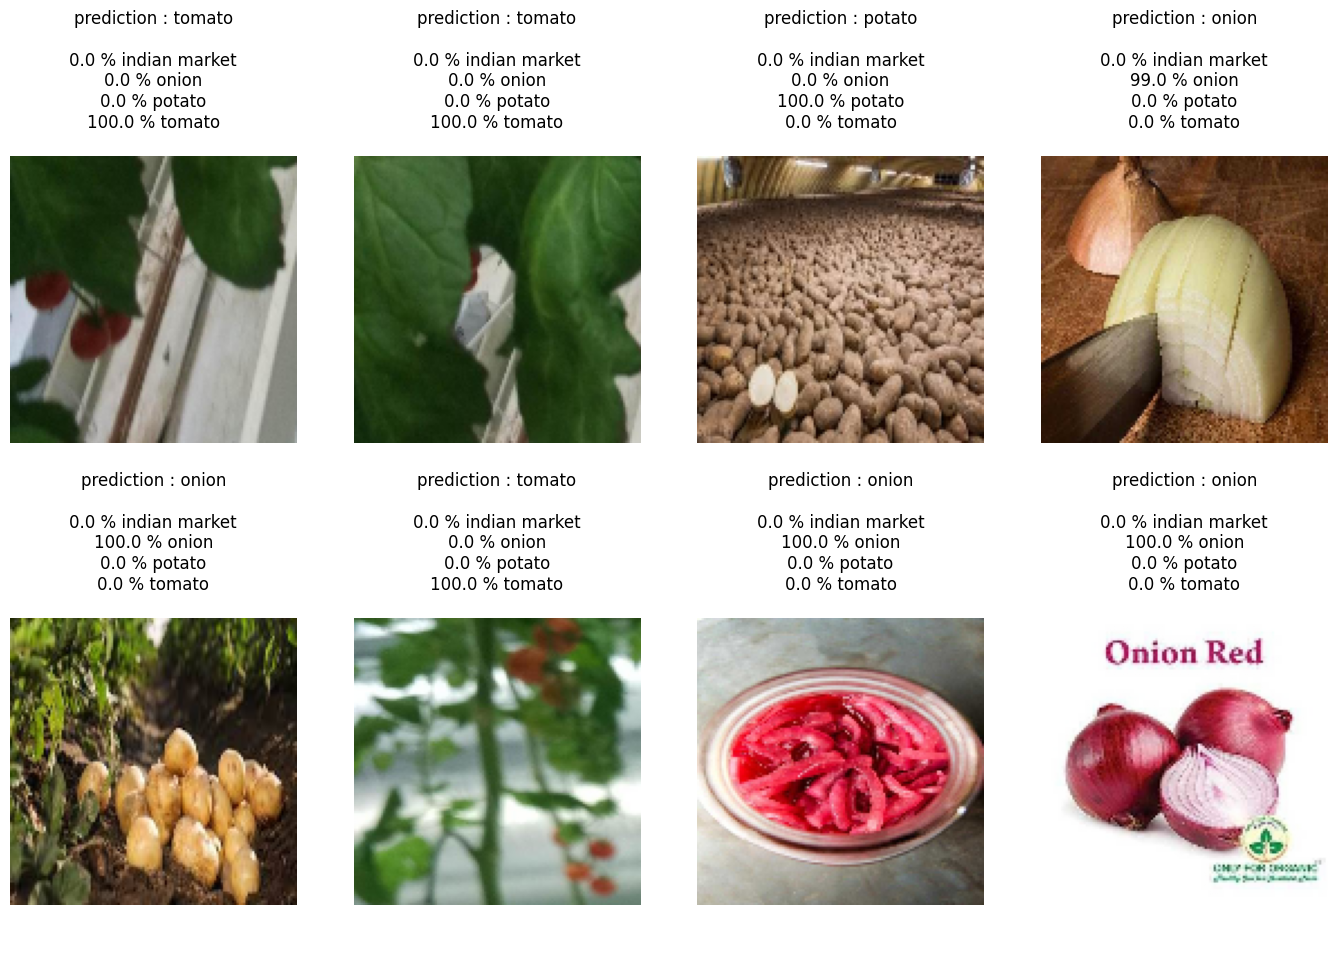

In [83]:
grid_test_model_1(model_2)

In [84]:
# Evaluate the model on the test set
loss, accuracy, precision, recall = model_2.evaluate(test_dsvgg)
print(f"Overall Loss: {loss:.4f}")
print(f"Overall Accuracy: {accuracy:.4f}")
print(f"Overall Precision: {precision:.4f}")
print(f"Overall Recall: {recall:.4f}")

44/44 [==============================] - 2s 33ms/step - loss: 0.2338 - accuracy: 0.9288 - precision: 0.9288 - recall: 0.9288
Overall Loss: 0.2338
Overall Accuracy: 0.9288
Overall Precision: 0.9288
Overall Recall: 0.9288


##### It performs exceptionally good

## Summary and Insights

* There was a 5% accuracy increment from 78% to 83% after modifying our custom CNN using augmentation,dropouts and batch Norm
* ResNet performs best among transfer Learned models by a small margin
* MobileNet could be a good choice as it almost performed equally well to ResNet with 7 times less parameters
* Image compression and limiting the number of epochs and batches were used to overcome GPU overflow
* The images were of different sizes and had to be brought to same size of either (256,256,3) or (128,128,3)
* Tomatoes are 100% identifiable because of their distinct color of green in the pictures